## Stage 1 

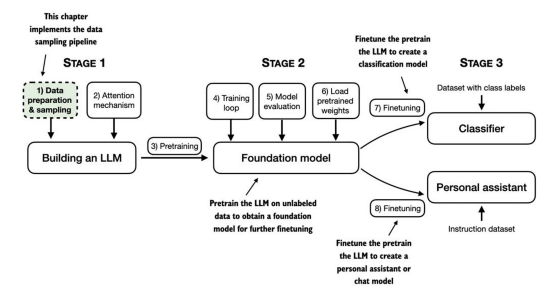

In [1]:
import re

In [3]:
with open("the_verdict.txt", "r", encoding =" utf-8") as f: 
    raw_text = f.read() 
    print(" Total number of character:", len( raw_text)) 
    print( raw_text[: 99])

 Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


### Tokenization and conversion to token ID

#### Regex tokenization

In [4]:
class SimpleTokenizerV1: 
    def __init__(self, text): 
        self.str_to_int = self.create_vocab(text) #A 
        self.int_to_str = {i:s for s, i in self.str_to_int.items()} #B 

    def create_vocab(self, text):
        preprocessed = re.split( r'([,.?_!"()\']|--|\s)', text) 
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        all_words = sorted(list( set(preprocessed)))
        return {token:integer for integer, token in enumerate(all_words)}
    
    def encode( self, text): #C 
        preprocessed = re.split( r'([,.?_!"()\']|--|\s)', text) 
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed] 
        return ids 
    
    def decode( self, ids): #D 
        text = " ". join([self.int_to_str[i] for i in ids]) 
        text = re.sub( r'\s +([,.?!"()\'])', r'\1', text) #E 
        return text

In [5]:
class SimpleTokenizerV2: 
    def __init__(self, text): 
        self.str_to_int = self.create_vocab(text) #A 
        self.int_to_str = {i:s for s, i in self.str_to_int.items()} #B 

    def create_vocab(self, text):
        preprocessed = re.split( r'([,.?_!"()\']|--|\s)', text) 
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        all_words = sorted(list( set(preprocessed)))
        all_words.extend(["<|endoftext|>", "<|unk|>"])
        return {token:integer for integer, token in enumerate(all_words)}
    
    def encode( self, text): #C 
        preprocessed = re.split( r'([,.?_!"()\']|--|\s)', text) 
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed] 
        return ids 
    
    def decode( self, ids): #D 
        text = " ". join([self.int_to_str[i] for i in ids]) 
        text = re.sub( r'\s +([,.?!"()\'])', r'\1', text) #E 
        return text

In [6]:
tokenizer = SimpleTokenizerV1(raw_text)

In [7]:
# ERROR IS NORMAL, BECAUSE HELLO NOT IN VOCAB
tokenizer.encode("Hello, do you like tea?")



KeyError: 'Hello'

In [8]:
tokenizer = SimpleTokenizerV2(raw_text)

In [9]:
text1 = "Hello, do you like tea?" 
text2 = "In the sunlit terraces of the palace." 
text = "<|endoftext|>". join(( text1, text2)) 
print( text)

tokenizer.encode(text)

Hello, do you like tea?<|endoftext|>In the sunlit terraces of the palace.


[1160, 5, 362, 1155, 642, 1000, 10, 1160, 1013, 981, 1009, 738, 1013, 1160, 7]

In [10]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|> , do you like tea ? <|unk|> the sunlit terraces of the <|unk|> .'

Depending on the LLM, some researchers also consider additional special tokens such as the following: 
- [BOS] (beginning of sequence): This token marks the start of a text. It signifies to the LLM where a piece of content begins. 
- [EOS] (end of sequence): This token is positioned at the end of a text, and is especially useful when concatenating multiple unrelated texts, similar to < | endoftext | >. For instance, when combining two different Wikipedia articles or books, the 
- [EOS] token indicates where one article ends and the next one begins. 
- [PAD] (padding): When training LLMs with batch sizes larger than one, the batch might contain texts of varying lengths. To ensure all texts have the same length, the shorter texts are extended or "padded" using the 
- [PAD] token, up to the length of the longest text in the batch.

#### Byte pair encoding

The algorithm underlying BPE breaks down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words. So, thanks to the BPE algorithm, if the tokenizer encounters an unfamiliar word during tokenization, it can represent it as a sequence of subword tokens or characters.

In [11]:
import tiktoken

In [12]:
tokenizer = tiktoken.get_encoding("gpt2")

In [13]:
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace." 
integers = tokenizer.encode( text, allowed_special ={"<|endoftext|>"}) 
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]


In [14]:
strings = tokenizer.decode( integers) 
print( strings)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.


### Data Sampling with Sliding Window

Use sliding window to create input and output tensors

In [15]:
enc_text = tokenizer.encode(raw_text) 
print( len( enc_text))
enc_sample = enc_text[ 50:]

5145


In [16]:
context_size = 4
for i in range( 1, context_size + 1): 
    context = enc_sample[:i] 
    desired = enc_sample[i]
    print( context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [17]:
import torch 
from torch.utils.data import Dataset, DataLoader 

class GPTDatasetV1(Dataset): 
    def __init__(self, txt, tokenizer, max_length, stride): 
        self.tokenizer = tokenizer 
        self.input_ids = [] 
        self.target_ids = [] 
        token_ids = tokenizer.encode( txt) #A 
        
        for i in range( 0, len( token_ids) - max_length, stride): #B 
            input_chunk = token_ids[ i:i + max_length] 
            target_chunk = token_ids[ i + 1: i + max_length + 1] 
            self.input_ids.append( torch.tensor( input_chunk)) 
            self.target_ids.append( torch.tensor( target_chunk)) 
        
    def __len__( self): #C
        return len( self.input_ids) 
    
    def __getitem__( self, idx): #D 
        return self.input_ids[ idx], self.target_ids[ idx]

In [18]:
def create_dataloader( txt, batch_size = 4, max_length = 256, stride = 128): 
    tokenizer = tiktoken.get_encoding("gpt2") #A 
    dataset = GPTDatasetV1( txt, tokenizer, max_length, stride) #B 
    dataloader = DataLoader( dataset, batch_size = batch_size) #C 
    return dataloader

In [26]:
# Note that an input size of 4 is relatively small and only chosen for illustration purposes. It is common to train LLMs with input sizes of at least 256.
# we increase the stride to 5, which is the max length + 1. This is to utilize the data set fully (we don't skip a single word) but also avoid any overlap between the batches, since more overlap could lead to increased overfitting.

dataloader = create_dataloader(raw_text, batch_size = 8, max_length = 4, stride = 5) 
data_iter = iter( dataloader) #A 
inputs, targets = next( data_iter) 

print(" Token IDs:\n", inputs) 
print("\nInputs shape:\n", inputs.shape)

 Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 3619,   402,   271, 10899],
        [  257,  7026, 15632,   438],
        [  257,   922,  5891,  1576],
        [  568,   340,   373,   645],
        [ 5975,   284,   502,   284],
        [  326,    11,   287,   262],
        [  286,   465, 13476,    11]])

Inputs shape:
 torch.Size([8, 4])


### Creating Token Embeddings

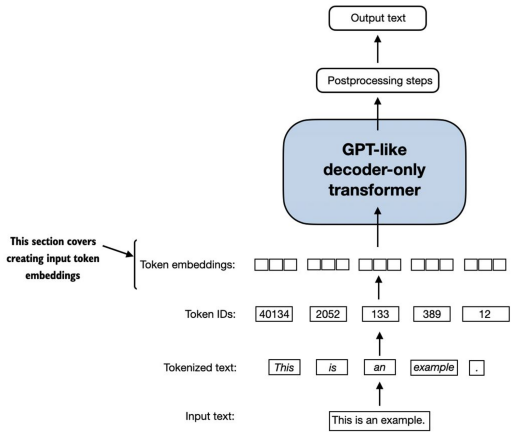

In [23]:
vocab_size = 50257
output_dim = 256 # embedding size

torch.manual_seed( 123) 
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim) 
print(token_embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.3035,  ...,  1.3337,  0.0771, -0.0522],
        [ 0.2386,  0.1411, -1.3354,  ..., -0.0315, -1.0640,  0.9417],
        [-1.3152, -0.0677, -0.1350,  ..., -0.3181, -1.3936,  0.5226],
        ...,
        [ 0.5871, -0.0572, -1.1628,  ..., -0.6887, -0.7364,  0.4479],
        [ 0.4438,  0.7411,  1.1263,  ...,  1.2091,  0.6781,  0.3331],
        [-0.2537,  0.1446,  0.7203,  ..., -0.2134,  0.2144,  0.3006]],
       requires_grad=True)


In [24]:
# retrieve embedding for token with id 3
print(token_embedding_layer( torch.tensor([3])))

tensor([[ 0.2579,  0.3420, -0.8168,  1.6772, -0.8353,  0.7531,  0.0821,  1.1650,
         -0.6635, -0.7809, -0.2270, -0.4358,  0.8209, -0.6353, -0.4386, -0.4472,
          1.5098, -0.0783,  0.7707,  0.5180,  0.2458,  0.3937, -0.7882,  0.3228,
         -0.7447,  0.3102, -1.4619, -0.1745, -0.5482, -0.4097, -0.0627,  0.0175,
          1.3715, -0.2226,  1.0566,  0.3687,  1.8359,  1.2957,  0.8045, -0.6188,
         -1.1795,  0.3383,  0.9319,  0.7436,  0.2490, -1.3814, -0.7985,  0.6369,
         -1.5530, -1.6292,  0.6107,  1.2718, -0.9422, -0.2667, -0.3216,  0.4504,
          0.3718,  0.6457,  0.5804,  0.3752,  0.4293, -0.7276, -0.5527,  0.6189,
         -1.4284,  0.5617,  0.7701,  0.3566, -0.1267,  0.9447,  0.1466,  0.2673,
          0.9467, -0.1406,  0.0329, -2.1542,  1.3953,  1.1845, -0.1255,  0.2517,
          1.3081,  0.1495,  1.1315,  0.2044,  1.2430, -0.0409,  0.7491,  0.3026,
         -0.7591, -0.9542, -1.6160, -0.1016, -1.1510, -1.8215,  1.1655, -2.3307,
          0.5062, -1.5363, -

### Encoding word positions

In [28]:
token_embeddings = token_embedding_layer( inputs)
token_embeddings.shape

torch.Size([8, 4, 256])

#### Absolute positional embeddings 

For each position in the input sequence, a unique embedding is added to the token's embedding to convey its exact location. For instance, the first token will have a specific positional embedding, the second token another distinct embedding, and so on, as illustrated in figure 2.18.

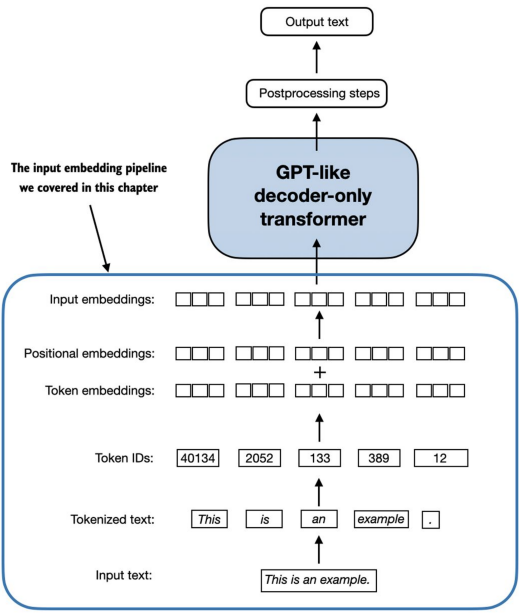

In [32]:

block_size = max_length 
pos_embedding_layer = torch.nn.Embedding( block_size, output_dim) 
pos_embeddings = pos_embedding_layer(torch.arange( block_size)) 
print( pos_embeddings.shape)

# add position embedding to token embedding (which comes with 8 batches)
input_embeddings = token_embeddings + pos_embeddings 
print( input_embeddings.shape)

torch.Size([4, 256])
torch.Size([8, 4, 256])


#### Relative positional embeddings.
The emphasis of relative positional embeddings is on the relative position or distance between tokens.